In [19]:
import tensorflow as tf

In [20]:
tf.__version__

'1.12.0'

In [21]:
mnist = tf.keras.datasets.mnist

In [22]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [23]:
print(x_train[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

In [24]:
import matplotlib.pyplot as plt

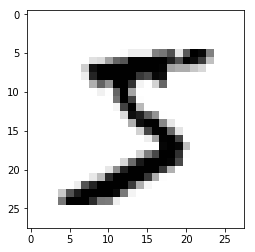

In [25]:
plt.imshow(x_train[0],cmap=plt.cm.binary)
plt.show()

In [26]:
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

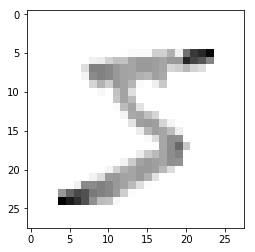

In [27]:
plt.imshow(x_train[0],cmap=plt.cm.binary)
plt.show()

In [52]:
model = tf.keras.models.Sequential()

In [53]:
model.add(tf.keras.layers.Flatten())

In [54]:
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))

In [55]:
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))

In [56]:
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

In [57]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [58]:
model.fit(x_train, y_train, epochs=3)

Epoch 1/3
60000/60000 [==============================] - 7s 122us/step - loss: 0.2666 - acc: 0.9221
Epoch 2/3
60000/60000 [==============================] - 7s 115us/step - loss: 0.1085 - acc: 0.9661
Epoch 3/3
60000/60000 [==============================] - 7s 122us/step - loss: 0.0743 - acc: 0.9762


In [59]:
val_loss, val_acc = model.evaluate(x_test, y_test)
print(val_loss)
print(val_acc)

10000/10000 [==============================] - 1s 74us/step
0.09737721924223006
0.9692


In [60]:
predictions = model.predict(x_test)

In [61]:
predictions

array([[1.9927164e-10, 4.1097781e-08, 1.2379840e-05, ..., 9.9973029e-01,
        5.6138447e-08, 3.8000099e-08],
       [2.7337272e-09, 2.6671227e-05, 9.9997139e-01, ..., 6.6576109e-09,
        1.1659759e-08, 1.1354927e-13],
       [2.3416060e-09, 9.9993527e-01, 2.4866472e-06, ..., 3.6350615e-05,
        1.6935424e-05, 3.5145473e-07],
       ...,
       [2.2021159e-10, 2.7815647e-06, 2.1380167e-08, ..., 3.6811583e-05,
        1.2205718e-06, 2.1483089e-05],
       [3.8852795e-06, 1.0585923e-06, 9.8954172e-07, ..., 3.1860855e-05,
        2.2039020e-01, 2.0446744e-06],
       [1.4227499e-05, 2.3336511e-09, 1.3849046e-05, ..., 1.3683809e-09,
        5.6504373e-06, 7.4603230e-09]], dtype=float32)

In [63]:
import numpy as np

print(np.argmax(predictions[100]))

6


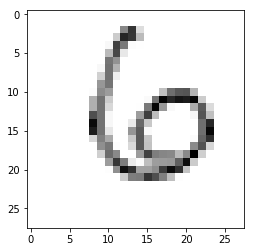

In [64]:
plt.imshow(x_test[100],cmap=plt.cm.binary)
plt.show()

In [65]:
# https://www.youtube.com/watch?v=wQ8BIBpya2k&list=PLQVvvaa0QuDfhTox0AjmQ6tvTgMBZBEXN